        a  WWWusage  points
time                       
1       1        88      88
2       2        84      84
3       3        85      85
4       4        85      85
5       5        84      84
...   ...       ...     ...
96     96       222     222
97     97       228     228
98     98       226     226
99     99       222     222
100   100       220     220

[100 rows x 3 columns]


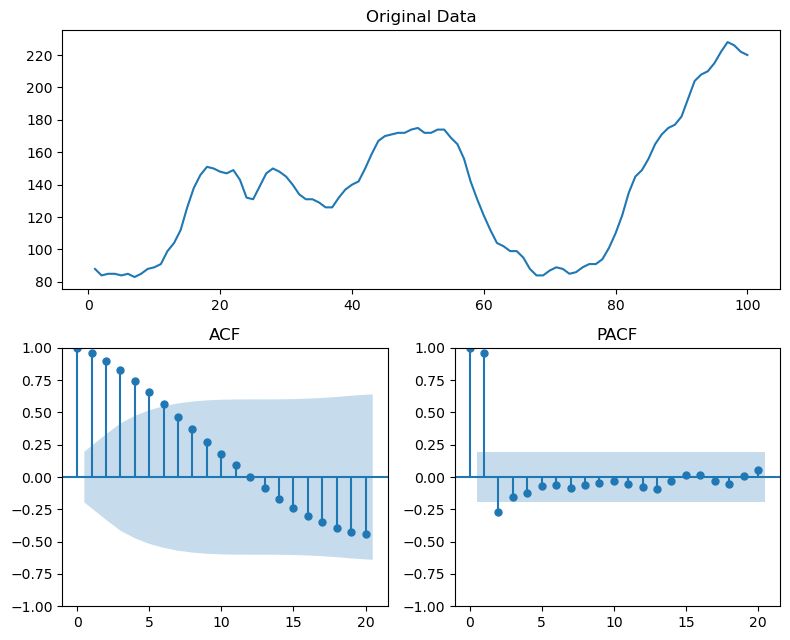

In [463]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import float128
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
test_with_artificial = False


def artificial_arima(p=np.array([]), d=0, q = np.array([]), f=lambda x:x, n = 100, m = 0):
    # generate synthetic data in order to validate our method for real data
    a  = np.random.normal(0,1,n)
    W = np.zeros(n)
    for t in range(n):   
        if t < len(p) or t < len(q):
            W[t] = 0 # maybe this can be done cleaner but whatever
        else:
            W[t] = - W[t-len(p):t] @ p[::-1] + a[t] + a[t-len(q):t] @ q[::-1] 
    
    for d_c in range(d):
        W = np.cumsum(W) 
        
    W += m    
        
    return f(W)
    
    


if test_with_artificial:
    n = 1000
    points = artificial_arima(
        p = np.array([0]),#.5, .6]),#np.array([0,0.1,0.2]),
        q = np.array([0]),#.3]),#np.array([0,0.1]),
        d = 1,
        f = lambda x:1.01**x,
        n = n,
        m = 0
    )
    dates = pd.date_range(start='1800-01-01', periods=n, freq='MS')
    
    # Create DataFrame with datetime index
    time_series_df = pd.DataFrame({'points': 1.7**points}, index=dates)
else:
    # Load the CSV file
    #time_series_df = pd.read_csv('data/csv_s33-bruttoinlandsprodukt.csv',
    #                             parse_dates=[0],  # Parse first column as dates
    #                             index_col=0)  # Set first column as index
    '''
    time_series_df = pd.read_csv('data/csv_s33-bruttoinlandsprodukt.csv', delimiter=';', decimal='.', parse_dates=[0], index_col = 0)
    time_series_df.index = pd.to_datetime(time_series_df.index, format='%Y', errors='coerce')

    freq = 'YE'
    time_series_df['points'] = time_series_df[' \"in Mrd \"']
    time_series_df['points'] = time_series_df['points'].astype(float)
    #time_series_df['points'] = time_series_df[' \"in Mrd. \"'].iloc[:, 0].replace(',', '', regex=True).astype(float
    '''
    '''
    time_series_df = pd.read_csv('data/future-gc00-daily-prices.csv', parse_dates=[0], index_col = 0)
    
    time_series_df['points'] = time_series_df["Open"].replace(",", "", regex=True).astype(float)
    time_series_df = time_series_df.reindex(pd.bdate_range(start=time_series_df.index.min(), end=time_series_df.index.max()))
    time_series_df['points'] = time_series_df['points'].interpolate()
    time_series_df = time_series_df
    freq = 'D'
    '''
    '''
    name = "Open"

    time_series_df = pd.read_csv("data/future-gc00-daily-prices.csv", index_col="Date")
    
    # Convert index to datetime if it's not already
    time_series_df.index = pd.to_datetime(time_series_df.index)
    
    # Sort by date in ascending order (oldest to newest)
    time_series_df = time_series_df.sort_index()
    
    time_series_df['points'] = time_series_df[name].replace(',', '', regex=True).astype(float)
    #result = adfuller(time_series_df['points'])
    #print(f"ADF Statistic: {result[0]}")
    #print(f"p-value: {result[1]}")
    
    time_series_df = time_series_df.ffill()
    #time_series_df['points'] = time_series_df[' \"in Mrd. \"'].iloc[:, 0].replace(',', '', regex=True).astype(float
    #time_series_df = time_series_df.dropna(how='any')
    '''
    # dataset from here https://www.kaggle.com/datasets/ukveteran/www-usage
    
    time_series_df = pd.read_csv('data/WWWusage.csv',  index_col='time', header = 0)
    time_series_df['points'] = time_series_df['WWWusage']
    
#time_series_df = time_series_df.asfreq(freq)
print(time_series_df)
def plot_series(series, series_title, alpha = 0.05):
    """
    Plots the time series, ACF, and PACF with custom titles in a 2-column layout.

    Parameters:
    - series: The time series data to plot.
    - series_title: Title for the time series plot.
    """
    # Create a figure with custom layout using gridspec
    fig = plt.figure(figsize=(8, 6.5))
    gs = fig.add_gridspec(2, 2)   # 1 row, 2 columns

    # First column: Time Series plot (span both rows)
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(series)
    ax0.set_title(series_title)

    # Second column: ACF and PACF plots
    # ACF plot
    ax1 = fig.add_subplot(gs[1, 0])
    plot_acf(series, ax=ax1, alpha=alpha)
    ax1.set_title("ACF")

    # PACF plot
    ax2 = fig.add_subplot(gs[1, 1])  # Reuse the same axis for PACF
    plot_pacf(series, ax=ax2, alpha=alpha)
    ax2.set_title("PACF")

    # Show the plots
    plt.tight_layout()
    plt.show()
    
    
plot_series(time_series_df['points'], "Original Data")




Use a full automatic test to which we can compare our results to

In [464]:
if False:
    import pmdarima as pm
    
    # Automatically fit the best ARIMA/SARIMA model
    model = pm.auto_arima(
        time_series_df['points'],
        seasonal=False,      # Enable seasonal differencing if necessary
        stepwise=True,      # Use stepwise algorithm for faster computation
        trace=True,         # Show the fitting process details
        max_p=6,              # Set maximum p value to control AR component
        max_q=6,              # Set maximum q value to control MA component
        max_d=1,              # Set maximum differencing order
        max_P=1,              # Set maximum seasonal AR order
        max_Q=1,              # Set maximum seasonal MA order
        max_D=1,
        max_order = 10
    )
    
    
    # Summary of the best model found
    print(model.summary())
    
    # Predict future values (e.g., next 12 periods)
    forecast = model.predict(n_periods=12)


Test stationarity, Augmented Dickey-Fuller unit root test.

In [465]:
#Check stationarity
# alternative hypothesis is stationarity 
st.adfuller(time_series_df['points'])


(-2.4642397172033688,
 0.12441935447109453,
 3,
 96,
 {'1%': -3.5003788874873405,
  '5%': -2.8921519665075235,
  '10%': -2.5830997960069446},
 444.67104090432554)

p value > 0.05 => we can not conclude stationarity

apply box cox transformation, and use scipy to estimate optimal box cox parameter lambda (todo explain what method scipy uses)

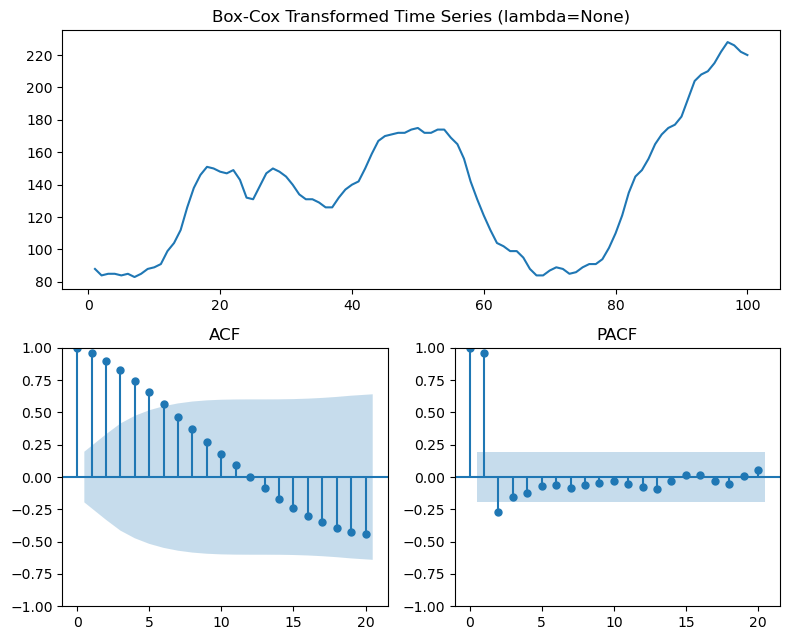

In [466]:
from scipy import stats
use_trafo = False
if use_trafo:
    # Apply Box-Cox transformation and estimate lambda
    lmbda = None
    if lmbda is None:
        transformed_prices, lmbda = stats.boxcox(time_series_df["points"])
    else:
        transformed_prices = stats.boxcox(time_series_df["points"], lmbda =lmbda)
    
    # Store the transformed values back into the DataFrame
    time_series_df['T_points'] = transformed_prices
    print("used lambda: ", lmbda)
else:
    lmbda = None
    time_series_df['T_points'] = time_series_df['points']
plot_series(time_series_df['T_points'], f"Box-Cox Transformed Time Series (lambda={lmbda})")
    


Differentiate and see when stationarity tests become positive

In [467]:
from statsmodels.sandbox.archive import tsa

alpha = 0.05

        

# Assuming 'time_series_df' is your DataFrame and 'Prices' is the column
current_series = time_series_df['T_points'].dropna()
differencing_count = 0

# Function to apply ADF test and get p-value
def get_adf_p_value(series):
    adf_result = st.adfuller(series.dropna())
    return adf_result[1]  # Return p-value from ADF test

# Keep iterating until the series is stationary or we reach the max differencing
while get_adf_p_value(current_series) >= alpha:
    differencing_count += 1
    # Apply first-order differencing
    #current_series = current_series.diff().dropna() # drop NaNs that come to existance by 
    # doing diff operation
    current_series = current_series.diff()#tsa.statespace.tools.diff(current_series)

    # Print progress with the p-value after differencing
    print(f"After {differencing_count} differencing(s), the ADF p-value is: {get_adf_p_value(current_series)}")

# Add the differenced series to the DataFrame
time_series_df['diff_points'] = current_series.copy()    

# Check if series is stationary after differencing
if get_adf_p_value(current_series) < alpha:
    print(f"Series is stationary after {differencing_count} differencings.")
    print("")
else:
    print("Max differencings reached without achieving stationarity.")





After 1 differencing(s), the ADF p-value is: 0.07026846015272693
After 2 differencing(s), the ADF p-value is: 2.843428755547158e-17
Series is stationary after 2 differencings.



Plot the new time series and acf and pcf

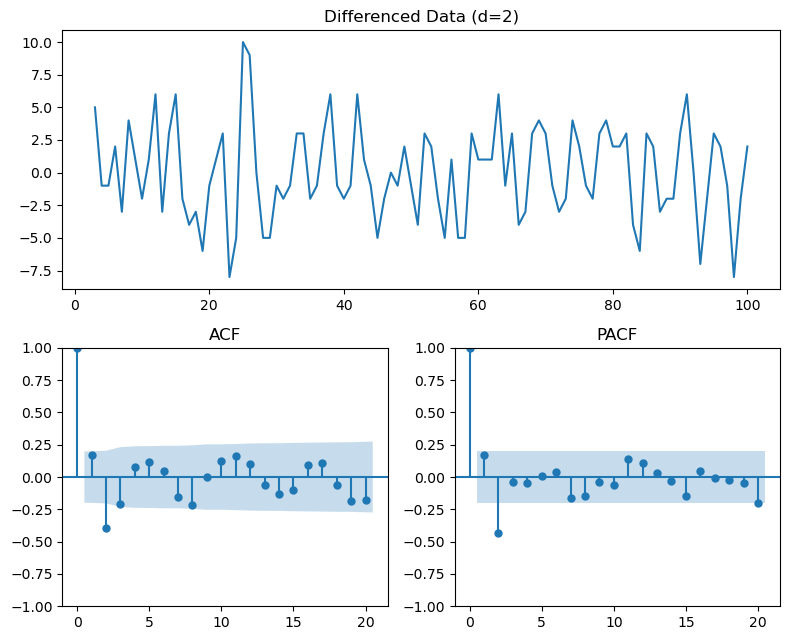

In [468]:
data = time_series_df['diff_points'].dropna() #dropnans from differentiating

plot_series(data, f"Differenced Data (d={differencing_count})", alpha = 0.05)



Print out all lags that are sginificantly non zero

In [469]:
data = time_series_df['diff_points'].dropna()

def print_significant_lags(data, alpha=0.05, nlags=30):
    """
    Calculate and print all significantly non-zero lags using ACF.
    
    Parameters:
    -----------
    data : array-like
        The time series data
    alpha : float, default=0.05
        Significance level for the confidence intervals
    nlags : int, default=40
        Number of lags to calculate
    
    Returns:
    --------
    tuple
        - List of significant lag indices
        - ACF values for significant lags
        - Confidence intervals
    """
    # Calculate ACF with confidence intervals
    acf_values, acf_confint = st.acf(data, alpha=alpha, fft=True, nlags=nlags, adjusted=True)
    pacf_values, pacf_confint = st.pacf(data, alpha=alpha, nlags=nlags)
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    acf_significant_lags = []
    acf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | ACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(acf_values)):
        lower_ci = acf_confint[lag][0]
        upper_ci = acf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            acf_significant_lags.append(lag)
            acf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {acf_values[lag]:9.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    # The confidence intervals come as [lower, upper] for each lag
    # If 0 is not in [lower, upper], the lag is significant
    pacf_significant_lags = []
    pacf_significant_values = []
    
    print(f"\nSignificant lags at {alpha*100}% significance level:")
    print("----------------------------------------")
    print("Lag | PACF Value | Confidence Interval")
    print("----------------------------------------")
    
    for lag in range(len(pacf_values)):
        lower_ci = pacf_confint[lag][0]
        upper_ci = pacf_confint[lag][1]
        
        # Check if 0 is outside the confidence interval
        if (lower_ci > 0) or (upper_ci < 0):
            pacf_significant_lags.append(lag)
            pacf_significant_values.append(acf_values[lag])
            print(f"{lag:3d} | {pacf_values[lag]:10.3f} | [{lower_ci:6.3f}, {upper_ci:6.3f}]")
    
    
    if not acf_significant_lags and not pacf_significant_lags:
        print("No significant lags found.")
   
    return (acf_significant_lags, acf_significant_values, acf_confint), (pacf_significant_lags, pacf_significant_values, pacf_confint)
sig = print_significant_lags(data)


Significant lags at 5.0% significance level:
----------------------------------------
Lag | ACF Value | Confidence Interval
----------------------------------------
  0 |     1.000 | [ 1.000,  1.000]
  2 |    -0.399 | [-0.603, -0.195]
 24 |    -0.339 | [-0.640, -0.038]

Significant lags at 5.0% significance level:
----------------------------------------
Lag | PACF Value | Confidence Interval
----------------------------------------
  0 |      1.000 | [ 1.000,  1.000]
  2 |     -0.443 | [-0.641, -0.245]
 20 |     -0.266 | [-0.464, -0.068]
 23 |     -0.258 | [-0.456, -0.061]
 24 |     -0.263 | [-0.461, -0.065]


From the significant acf and pacf lags and the acf and pacf graphs we can
propose these models: (TODO adjat models to real life data and add explanations)
ARIMA(5,1,0)
ARIMA(0,1,5)
ARIMA(5,1,5)




## Estimate Parameters


ARIMA(0,2,0):
AIC: 531.48
BIC: 534.06

ARIMA(1,2,0):
AIC: 530.44
BIC: 535.61

ARIMA(0,2,1):
AIC: 523.90
BIC: 529.07

ARIMA(2,2,1):
AIC: 513.26
BIC: 523.60

ARIMA(2,2,2):
AIC: 515.13
BIC: 528.06


/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

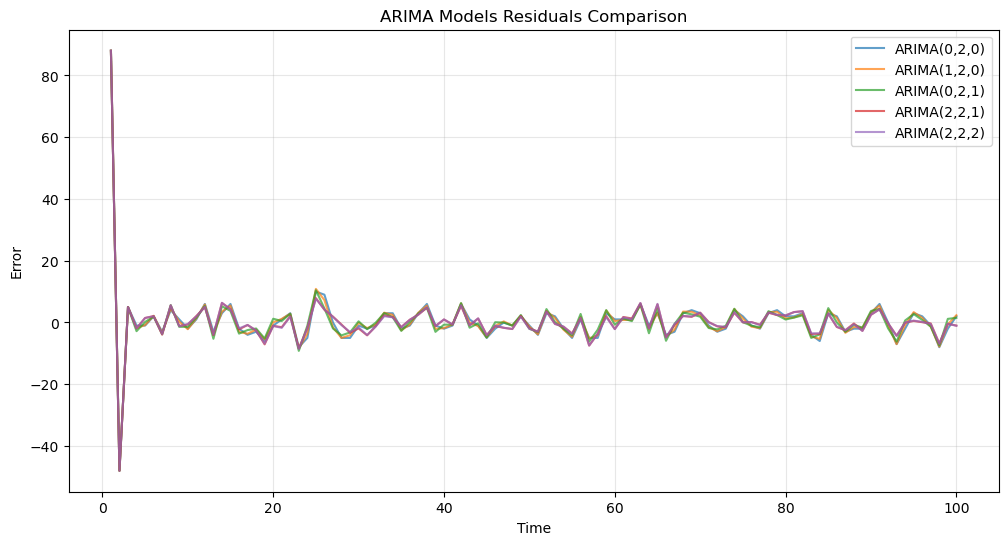

In [470]:
from statsmodels.tsa.arima.model import ARIMA

data = time_series_df['T_points'].dropna()

suggested_models = np.array([
    [0,2,0],
    [1,2,0],
    [0,2,1],
    [2,2,1],
    [2,2,2]
])
results = []
error_dfs = []  
fitted_models = []
for p, d, q in suggested_models:
    model = ARIMA(data, order=(p, d, q))
    fitted = model.fit()
    
    results.append({
        'order': f"ARIMA({p},{d},{q})",
        'aic': fitted.aic,
        'bic': fitted.bic,
        'p': p,
        'd': d,
        'q': q
    })
    
    print(f"\nARIMA({p},{d},{q}):")
    print(f"AIC: {fitted.aic:.2f}")
    print(f"BIC: {fitted.bic:.2f}")
    
    
    # Get residuals and add to list
    residuals = pd.DataFrame(fitted.resid)
    residuals.columns = [f'ARIMA({p},{d},{q})']
    error_dfs.append(residuals)
    
    
    # Store the fitted model object
    fitted_models.append(fitted)
    
    
# Combine all residuals into one DataFrame
all_errors = pd.concat(error_dfs, axis=1)


# Create a DataFrame for the fitted models
fitted_models_df = pd.DataFrame({
    'model_order': [f"ARIMA({p},{d},{q})" for p, d, q in suggested_models],
    'fitted_model': fitted_models
})

# Plot using matplotlib
plt.figure(figsize=(12, 6))
for column in all_errors.columns:
    plt.plot(all_errors.index, all_errors[column], label=column, alpha=0.7)
plt.legend()
plt.title('ARIMA Models Residuals Comparison')
plt.xlabel('Time')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)
plt.show()

#plot_series(all_errors['ARIMA(1,1,1)'], "timeseries of residuals")


        

## Verify 8 supuestos

### Tests on residuals, Supuestos 1-4


In [471]:

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro, jarque_bera, ttest_1samp
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
import statsmodels.stats.weightstats as smw

# Example residuals DataFrame (assuming you've created it as `all_errors` before)
# all_errors contains residuals for each ARIMA model
# Iterate over each model's residuals and perform tests

# Initialize a list to store the test results
residuals_tests = []

data = time_series_df['T_points'].dropna()

# Function to test residuals
def test_residuals(residuals, model_name, alpha = 0.05):
    results = {}
    # 1. Test if 
    # Perform a t-test to check if the mean is significantly different from 0
    p_value = ttest_1samp(residuals, 0).pvalue
    results['mean_close_to_0'] = p_value > alpha  # Within tolerance
    print(f"{model_name}: Mean of residuals = {np.mean(residuals):.4f}, p_value = {p_value:.4f}")
    

    # 2. Check for constant variance (Homoscedasticity) using Breusch-Pagan test
    _, pvalue, _, _ = het_breuschpagan(residuals, sm.add_constant(np.arange(len(residuals))))
    results['constant_variance'] = pvalue > alpha
    print(f"{model_name}: Homoscedasticity (Breusch-Pagan p-value) = {pvalue:.4f}")

    # 3. Normality Tests
    # Shapiro-Wilk test
    _, shapiro_pvalue = shapiro(residuals)
    # Jarque-Bera test
    jb_stat, jb_pvalue = jarque_bera(residuals)
    results['normal_distribution'] = shapiro_pvalue > alpha and jb_pvalue > alpha
    print(f"{model_name}: Normality (Shapiro-Wilk p-value) = {shapiro_pvalue:.4f}")
    print(f"{model_name}: Normality (Jarque-Bera p-value) = {jb_pvalue:.4f}")

    # 4. Independence Test using Ljung-Box test
    # Setting a maximum lag of 10 (adjust as necessary)
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    pvalue_ljungbox = lb_test['lb_pvalue'].values[0]
    results['independent_errors'] = pvalue_ljungbox > alpha
    print(f"{model_name}: Independence (Ljung-Box p-value) = {pvalue_ljungbox:.4f}")

    # Store results in the residuals_tests list
    residuals_tests.append({'model': model_name, 'results': results})
    if False:
        # Additional Plots
        plt.figure(figsize=(10, 6))
    
        # Histogram and Q-Q plot
        plt.subplot(1, 2, 1)
        plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'{model_name} Residuals Histogram')
        plt.axvline(x=0, color='red', linestyle='--', label='Mean = 0')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sm.qqplot(residuals, line='s')
        plt.title(f'{model_name} Q-Q Plot')
    
        plt.tight_layout()
        plt.show()
    
    print("-" * 40)
    
    
# Iterate over each column in all_errors DataFrame
for column in all_errors.columns:
    print("column", column)
    residuals = all_errors[column].dropna()  # Drop NaNs if they exist
    test_residuals(residuals, column)

# Print summary of results
print("\nSummary of Residuals Assumptions Check:")
for result in residuals_tests:
    model_name = result['model']
    tests = result['results']
    print(f"{model_name}:")
    print(f"  Mean close to 0: {'Pass' if tests['mean_close_to_0'] else 'Fail'}")
    print(f"  Constant Variance: {'Pass' if tests['constant_variance'] else 'Fail'}")
    print(f"  Normal Distribution: {'Pass' if tests['normal_distribution'] else 'Fail'}")
    print(f"  Independent Errors: {'Pass' if tests['independent_errors'] else 'Fail'}")
    print("-" * 40)
#

column ARIMA(0,2,0)
ARIMA(0,2,0): Mean of residuals = 0.4200, p_value = 0.6951
ARIMA(0,2,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0311
ARIMA(0,2,0): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(0,2,0): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(0,2,0): Independence (Ljung-Box p-value) = 0.1379
----------------------------------------
column ARIMA(1,2,0)
ARIMA(1,2,0): Mean of residuals = 0.4200, p_value = 0.6946
ARIMA(1,2,0): Homoscedasticity (Breusch-Pagan p-value) = 0.0310
ARIMA(1,2,0): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(1,2,0): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(1,2,0): Independence (Ljung-Box p-value) = 0.1017
----------------------------------------
column ARIMA(0,2,1)
ARIMA(0,2,1): Mean of residuals = 0.4206, p_value = 0.6932
ARIMA(0,2,1): Homoscedasticity (Breusch-Pagan p-value) = 0.0306
ARIMA(0,2,1): Normality (Shapiro-Wilk p-value) = 0.0000
ARIMA(0,2,1): Normality (Jarque-Bera p-value) = 0.0000
ARIMA(0,2,1): Independence (Ljung-Box p-valu

### Supuesto 5: Modelo Parsimonioso

In [472]:
# Create lists to store models that pass and fail the test
models_pass = []
models_fail = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the confidence intervals for the parameters
    conf_intervals = fitted_model.conf_int()
    parameters = fitted_model.params
    
    print(f"\nParameters for {model_order}:")
    print(parameters)
    
    print(f"\nConfidence Intervals for {model_order}:")
    print(conf_intervals)
    print("-" * 50)
    
    # Check if all confidence intervals do not contain zero
    intervals_do_not_contain_zero = (conf_intervals[0] > 0) | (conf_intervals[1] < 0)
    
    if intervals_do_not_contain_zero.all():
        # If all parameters' confidence intervals do not contain zero
        models_pass.append(model_order)
    else:
        # If any parameter's confidence interval contains zero
        models_fail.append(model_order)

# Print the results
print("\nSummary of ARIMA Model Significance Parameters non zero Based on Confidence Intervals:")
print("===================================================")
print("Models that Passed (Confidence Intervals do NOT contain zero):")
print(models_pass)
print("\nModels that Failed (Confidence Intervals contain zero):")
print(models_fail)



Parameters for ARIMA(0,2,0):
sigma2    12.999956
dtype: float64

Confidence Intervals for ARIMA(0,2,0):
               0          1
sigma2  9.180565  16.819346
--------------------------------------------------

Parameters for ARIMA(1,2,0):
ar.L1      0.175675
sigma2    12.599699
dtype: float64

Confidence Intervals for ARIMA(1,2,0):
               0          1
ar.L1  -0.012954   0.364305
sigma2  8.959910  16.239488
--------------------------------------------------

Parameters for ARIMA(0,2,1):
ma.L1      0.427802
sigma2    11.765642
dtype: float64

Confidence Intervals for ARIMA(0,2,1):
               0          1
ma.L1   0.241575   0.614028
sigma2  8.496049  15.035235
--------------------------------------------------

Parameters for ARIMA(2,2,1):
ar.L1      0.351290
ar.L2     -0.457221
ma.L1     -0.116200
sigma2    10.104287
dtype: float64

Confidence Intervals for ARIMA(2,2,1):
               0          1
ar.L1  -0.111319   0.813899
ar.L2  -0.646739  -0.267703
ma.L1  -0.614070   

### Supuesto 6, modelos crean seria estationario y invertible

In [473]:
# Create lists to store models that pass and fail the stationary test
admisible_models = []
non_admisible_models = []

# Iterate over each fitted model in the DataFrame
for index, row in fitted_models_df.iterrows():
    # Get the model order and fitted model object
    model_order = row['model_order']
    fitted_model = row['fitted_model']
    
    # Get the MA parameters from the model's parameters
    ma_params = [param for param in fitted_model.params.index if 'ma.L' in param]
        
    # Extract the MA parameter values
    ma_coefficients = [fitted_model.params[param] for param in ma_params]
    
    # Compute the roots of the MA polynomial: 1 - p1*x - p2*x^2 - ...
    ma_roots = np.roots(([1] + [-coeff for coeff in ma_coefficients])[::-1])  # Coefficients are negated
    
    # Get the AR parameters from the model's parameters
    ar_params = [param for param in fitted_model.params.index if 'ar.L' in param]
        
    # Extract the MA parameter values
    ar_coefficients = [fitted_model.params[param] for param in ar_params]
    
    # Compute the roots of the MA polynomial: 1 - p1*x - p2*x^2 - ...
    ar_roots = np.roots(([1] + [-coeff for coeff in ar_coefficients])[::-1])  # Coefficients are negated
    
    
    # Check if all roots are outside the unit circle (i.e., absolute value > 1)
    if np.all(np.abs(ma_roots) > 1) and np.all(np.abs(ar_roots) > 1):
        admisible_models.append(model_order)
    else:
        non_admisible_models.append(model_order)

# Print the results
print("\nSummary of Admisibility Test Based on MA and AR Polynomial Roots:")
print("===================================================")
print("Models that Passed (Admisible Models with Roots Outside the Unit Circle):")
print(admisible_models)
print("\nModels that Failed (Non-Admisible Models with Roots Inside or on the Unit Circle):")
print(non_admisible_models)


Summary of Admisibility Test Based on MA and AR Polynomial Roots:
Models that Passed (Admisible Models with Roots Outside the Unit Circle):
['ARIMA(0,2,0)', 'ARIMA(1,2,0)', 'ARIMA(0,2,1)', 'ARIMA(2,2,1)', 'ARIMA(2,2,2)']

Models that Failed (Non-Admisible Models with Roots Inside or on the Unit Circle):
[]


### Supuesto 7, 

check if correlations between estimated parameters are small



In [474]:
from statsmodels.stats.moment_helpers import cov2corr

# Loop over each ARIMA model in the fitted_models_df DataFrame
for idx, row in fitted_models_df.iterrows():
    model_name = row['model_order']
    fitted_model = row['fitted_model']
    
    # Extract the variance-covariance matrix of parameters
    cov_matrix = fitted_model.cov_params()
    correlation_matrix = cov2corr(cov_matrix)
    # Create a DataFrame for easier readability
    correlation_df = pd.DataFrame(correlation_matrix, 
                                  index=fitted_model.param_names, 
                                  columns=fitted_model.param_names)
    
    # Display the correlation matrix
    print(f"\nCorrelation Matrix of Parameters for {model_name}:")
    print(correlation_df)



Correlation Matrix of Parameters for ARIMA(0,2,0):
        sigma2
sigma2     1.0

Correlation Matrix of Parameters for ARIMA(1,2,0):
          ar.L1   sigma2
ar.L1   1.00000  0.12246
sigma2  0.12246  1.00000

Correlation Matrix of Parameters for ARIMA(0,2,1):
           ma.L1    sigma2
ma.L1   1.000000  0.045302
sigma2  0.045302  1.000000

Correlation Matrix of Parameters for ARIMA(2,2,1):
           ar.L1     ar.L2     ma.L1    sigma2
ar.L1   1.000000 -0.488762 -0.900745  0.196490
ar.L2  -0.488762  1.000000  0.431034 -0.103760
ma.L1  -0.900745  0.431034  1.000000 -0.107411
sigma2  0.196490 -0.103760 -0.107411  1.000000

Correlation Matrix of Parameters for ARIMA(2,2,2):
           ar.L1     ar.L2     ma.L1     ma.L2    sigma2
ar.L1   1.000000 -0.141192 -0.900061 -0.092983  0.230904
ar.L2  -0.141192  1.000000  0.125011 -0.870712  0.121231
ma.L1  -0.900061  0.125011  1.000000  0.073469 -0.144525
ma.L2  -0.092983 -0.870712  0.073469  1.000000 -0.216743
sigma2  0.230904  0.121231 -0.1445

### Supuesto 8
Check if outliers have an influence on the result. Not needed since we dont have outliers

## Calculate the Forecast and confidence intervalls

In [477]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import special

# Define the number of periods to forecast and the confidence level
confidence_level = 0.75  # Confidence level for plotting 

# List of models to use
models_to_forecast = ['ARIMA(2,2,2)', 'ARIMA(0,2,0)']

def forecast(data, models_to_forecast, start, end, lmbda=None):
    # if lmbda is not None, Box-Cox transformation was applied, and we need to handle inverse transformation
    
    forecast_results = {}
    
    # Retrieve the last portion of the original data
    data_to_plot = data[start-(end-start)*2:]
    
    # Create a date range for the forecasted periods
    if start < len(data):
        start_date = data.index[start]

        # Create the forecast index
        forecast_index = pd.date_range(start=start_date, periods=np.abs(end-start)+1, freq=freq)
    else:
        last_date = data.index[-1]
        overlap = start - len(data) +1
        forecast_index = pd.date_range(start=last_date, periods=np.abs(end-start)+overlap+1, freq=freq)[overlap:]
    
    
    # Iterate over each model in the DataFrame and forecast
    for model_name in models_to_forecast:
        # Retrieve the fitted model from the DataFrame
        fitted_model = fitted_models_df.loc[fitted_models_df['model_order'] == model_name, 'fitted_model'].iloc[0]
        
        # Forecast the next n periods with the specified confidence level
        #forecast = fitted_model.get_forecast(steps=n_periods)
        forecast = fitted_model.get_prediction(start=start, end=end)
        # Get the predicted mean and confidence intervals
        forecast_mean = forecast.predicted_mean
        forecast_ci = forecast.conf_int(alpha=1 - confidence_level)  # Adjust alpha for the confidence interval
        
        # If lmbda is provided, apply inverse Box-Cox transformation to return to original scale
        if lmbda is not None:
            var = np.var(fitted_model.resid)
            if lmbda == 0:
                correction_factor = np.exp(var/2)
            else:
                correction_factor = (.5 + np.sqrt(1-2*lmbda*(lmbda-1)*(1+lmbda * forecast_mean)**(-1)*var)/2)**(1/lmbda) 
            
            forecast_mean = special.inv_boxcox(forecast_mean, lmbda) * correction_factor
            
            forecast_ci['lower T_points'] =forecast_ci['lower T_points'].apply(lambda x: special.inv_boxcox(x, lmbda)) * correction_factor
            forecast_ci['upper T_points'] = forecast_ci['upper T_points'].apply(lambda x: special.inv_boxcox(x, lmbda)) * correction_factor
            
            
        # Store the forecast results for plotting
        forecast_results[model_name] = {
            'forecast_mean': forecast_mean,
            'forecast_ci': forecast_ci
        }
        
        # Print the forecasted values and confidence intervals
        print(f"\nForecast for {model_name} for the next {end-start} periods with {confidence_level*100:.1f}% Confidence Interval:")
        print(forecast_mean)
        print("\nConfidence Interval:")
        print(forecast_ci)
        
        # Loop over the forecast index and compare with the original data
        print("\nComparison of Forecasts with Original Data:")
        print("Date\t\tForecast\tOriginal Data\tDifference")
        
        for date, forecast_value in zip(forecast_index, forecast_mean):
            # Check if the date exists in the original data
            if date in data.index:
                original_value = data.loc[date]
                difference = original_value - forecast_value
                print(f"{date.strftime('%Y-%m-%d')}\t{forecast_value:.2f}\t\t{original_value:.2f}\t\t\t{difference:.2f}")
            else:
                print(f"{date.strftime('%Y-%m-%d')}\t{forecast_value:.2f}\t\tData Not Available")
        

        
        print("-" * 40)
        
    # Plot the forecasts from both models
    plt.figure(figsize=(10, 6))
    
    # Plot the last portion of the original data
    plt.plot(data_to_plot.index, data_to_plot, label='Original Data', color='blue')
    
    
    
    # Plot forecasts and confidence intervals for each model
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    for i, (model_name, result) in enumerate(forecast_results.items()):
        forecast_mean = result['forecast_mean']
        forecast_ci = result['forecast_ci']
        
        # Plot forecasted values
        plt.plot(forecast_index, forecast_mean, label=f'Forecast - {model_name}', color=colors[i], marker='o')
        
        # Plot confidence intervals
        plt.fill_between(forecast_index,
                         forecast_ci.iloc[:, 0],
                         forecast_ci.iloc[:, 1],
                         color=colors[i], alpha=0.2)
    
    
    # Finalize the plot
    plt.title(f'Forecast Comparison for ARIMA(1,1,1) and ARIMA(1,1,0) with {confidence_level*100:.1f}% Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



### Predict in sample values


Forecast for ARIMA(2,2,2) for the next 9 periods with 75.0% Confidence Interval:
time
91     188.795067
92     204.255909
93     212.313958
94     210.010107
95     214.378273
96     221.812868
97     228.491710
98     232.897782
99     222.404459
100    221.055809
Name: predicted_mean, dtype: float64

Confidence Interval:
      lower T_points  upper T_points
time                                
91        185.140850      192.449285
92        200.601692      207.910126
93        208.659741      215.968175
94        206.355889      213.664324
95        210.724056      218.032490
96        218.158651      225.467085
97        224.837493      232.145927
98        229.243565      236.551999
99        218.750242      226.058676
100       217.401592      224.710026

Comparison of Forecasts with Original Data:
Date		Forecast	Original Data	Difference
1970-01-01	188.80		Data Not Available
1970-01-02	204.26		Data Not Available
1970-01-03	212.31		Data Not Available
1970-01-04	210.01		Data Not Ava

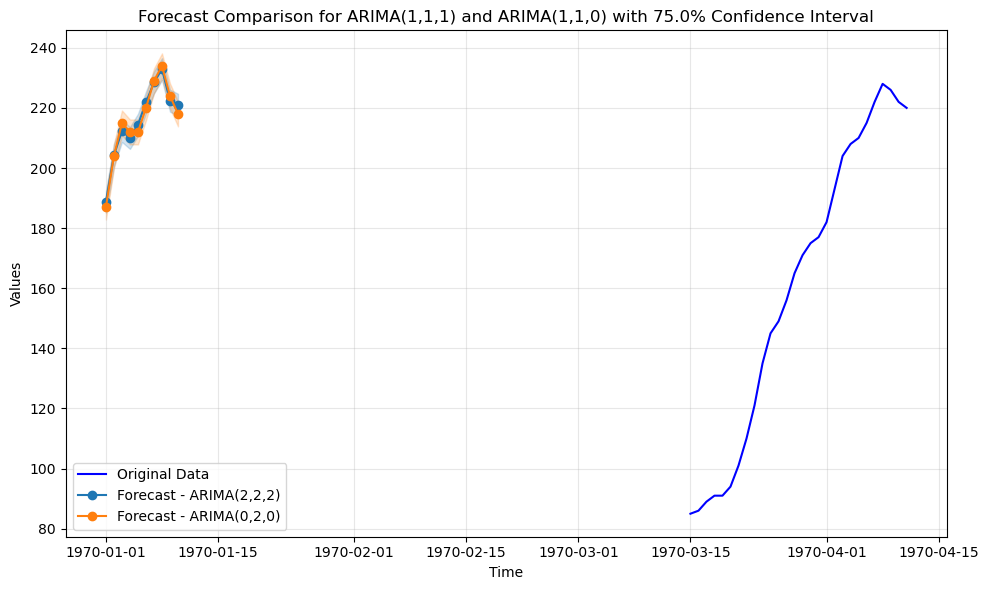

In [478]:
num_predictions = 10
end = len(time_series_df['points']) -1
start = end-(num_predictions-1)
forecast(time_series_df['points'], models_to_forecast, start=start, end=end, lmbda=lmbda)


### Predict out of sample values


Forecast for ARIMA(0,1,1) for the next 9 periods with 75.0% Confidence Interval:
100    218.917003
101    218.917003
102    218.917003
103    218.917003
104    218.917003
105    218.917003
106    218.917003
107    218.917003
108    218.917003
109    218.917003
Name: predicted_mean, dtype: float64

Confidence Interval:
     lower T_points  upper T_points
100      214.556403      223.277602
101      209.946739      227.887267
102      207.004134      230.829871
103      204.656314      233.177692
104      202.643772      235.190234
105      200.854089      236.979917
106      199.226404      238.607601
107      197.723361      240.110645
108      196.320072      241.513934
109      194.998974      242.835031

Comparison of Forecasts with Original Data:
Date		Forecast	Original Data	Difference
1970-01-02	218.92		Data Not Available
1970-01-03	218.92		Data Not Available
1970-01-04	218.92		Data Not Available
1970-01-05	218.92		Data Not Available
1970-01-06	218.92		Data Not Available
1970-01-

/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/daniels/.conda/envs/adlr/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without 

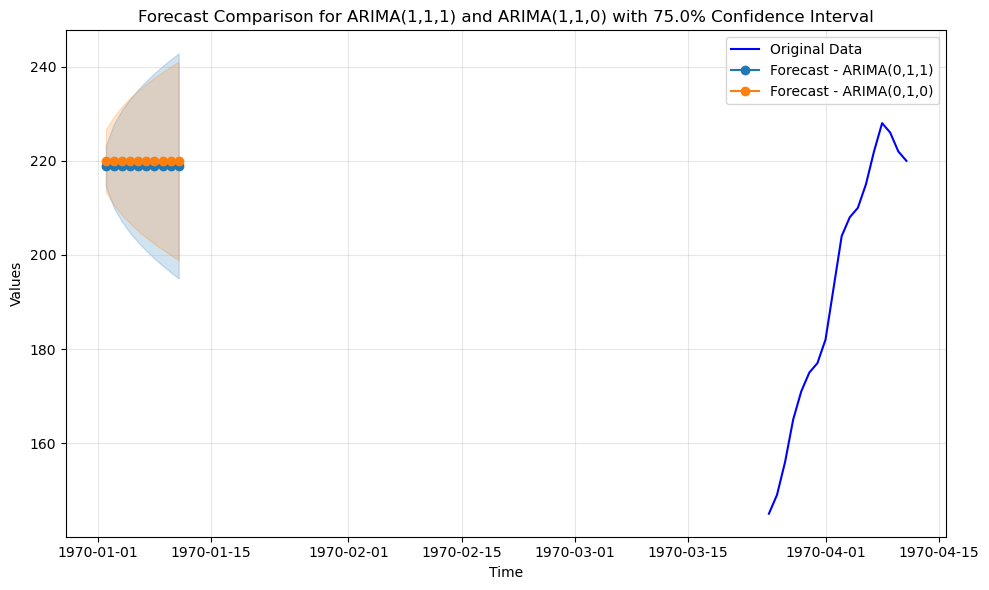

In [460]:
num_predictions = 10
start= len(time_series_df['points'])
end = start+num_predictions-1

forecast(time_series_df['points'], models_to_forecast, start=start, end=end, lmbda=lmbda)